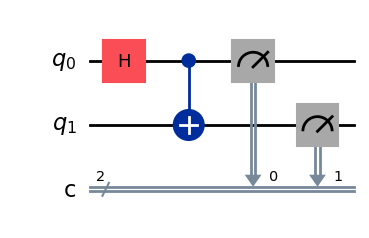

In [38]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)
circ.measure(0, 0)
circ.measure(1, 1)

circ.draw('mpl')

In [39]:
from qiskit import transpile, pulse
from qiskit.providers.fake_provider import FakeOpenPulse2Q
 
backend = FakeOpenPulse2Q()
 
d0 = pulse.DriveChannel(0)
 
with pulse.build() as pulse_prog:
    pulse.play(pulse.Constant(100, 0.5), d0)

In [46]:
from qiskit import pulse
from qiskit.pulse.library import Gaussian



with pulse.build(backend, name='h') as h_q0:
    pulse.play(Gaussian(duration=128, amp=0.2, sigma=6000), pulse.drive_channel(0))

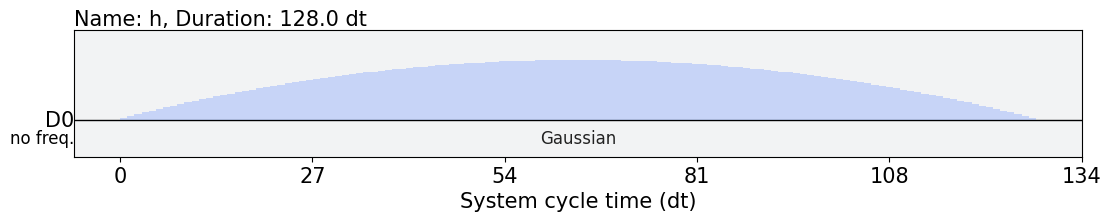

In [47]:
h_q0.draw()

['u1', 'u2', 'u3', 'cx', 'id']


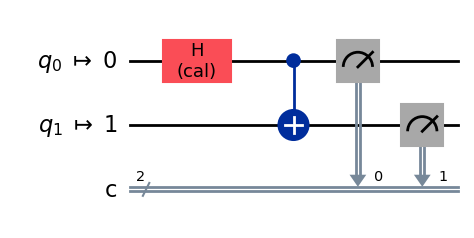

In [48]:
circ.add_calibration('h', [0], h_q0)
from qiskit import transpile


circ = transpile(circ, backend)

print(backend.configuration().basis_gates)
circ.draw('mpl', idle_wires=False)

In [53]:
job = backend.run(circ,shots=5000)

C:\Users\pop75\AppData\Roaming\Python\Python311\site-packages\qiskit\providers\fake_provider\fake_backend.py:153: RuntimeWarning: Aer not found using BasicAer and no noise
  warnings.warn("Aer not found using BasicAer and no noise", RuntimeWarning)


In [52]:
job.result().get_counts()

{'11': 2529, '00': 2471}